# GeoPandas Gridding Example

*Rob Knapen, Wageningen Environmental Research*
<br>

A notebook for trying out GeoPandas for gridding species observations.

### Import Python Packages

In [1]:
import os

import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gp

import shapely

### Load sample species observation data
As an example a dataset from the Dutch 'Nationale Databank Flora en Fauna' (ndff.nl). While we are hoping for this to be available as open data (soon), it is not yet. However, we have permission to use it for the FAIRiCUBE EU project.

In [2]:
# the NDFF datafile to process
obs_filename = "../../../local/data/ndff/overigesoorten_2016.csv"

# the columns to drop right away
always_drop_cols_from_source = None

# area of interest
aoi_epsg = 'EPSG:32631' # WGS 84 / UTM zone 31N
aoi_xmin =  674900.0
aoi_xmax =  729800.0
aoi_ymin = 5832230.0
aoi_ymax = 5853960.0

### Use a Pandas DataFrame for some pre-processing
Do some initial cleaning of the data first. Also fix the geometry data so it fits GeoPandas expectations.

In [3]:
# load the data into a regular pandas dataframe
obs_df = pd.read_csv(obs_filename, header='infer', sep=';', on_bad_lines='warn')

# remove not needed columns
if always_drop_cols_from_source:
    obs_df.drop(columns=always_drop_cols_from_source, inplace=True)

# remove the crs prefix from the wkt data
obs_df['wkt_excl_crs'] = obs_df['wkt'].map(lambda x: x.split(';')[1], na_action='ignore')
obs_df.drop(columns=['wkt'], inplace=True)
obs_df.rename(columns={'wkt_excl_crs': 'wkt'}, inplace=True)

obs_df.head(5)

,obs_uri,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,wkt
0,http://ndff.nl/app/observation/004b8606-9f7d-7...,Paardenbijter,Aeshna mixta,2016,levend exemplaar,3,71,"POLYGON((201846.994196555 387310.325765192,201..."
1,http://ndff.nl/telmee/observations/116869579,Gewone oeverlibel,Orthetrum cancellatum,2016,levend exemplaar,3,283,"POLYGON((91136.4726110989 443044.194701222,911..."
2,http://ndff.nl/app/observation/19f2833c-79e4-f...,Citroenvlinder,Gonepteryx rhamni,2016,levend exemplaar,1,71,"POLYGON((152931.103142183 445506.187935355,152..."
3,http://ndff.nl/telmee/observations/116869611,Icarusblauwtje,Polyommatus icarus,2016,levend exemplaar,1,71,"POLYGON((68831.2757593919 444283.292744242,688..."
4,http://ndff.nl/telmee/observations/116869591,Boomblauwtje,Celastrina argiolus,2016,levend exemplaar,1,71,"POLYGON((180015.605299007 366408.956150623,180..."


### Lift the data into a GeoPandas GeoDataFrame
Create a GeoPandas GeoDataFrame from the regular (non spatial aware) DataFrame. After that use GeoPandas functionality to transform the data from the Dutch coordinate reference system to the preferred CRS for the area of interest.

In [4]:
# note that we used the pandas dataframe
obs_gs = gp.GeoSeries.from_wkt(obs_df['wkt'])
obs_gdf = gp.GeoDataFrame(obs_df, geometry=obs_gs, crs='EPSG:28992')

# transform the dataset to the CRS of the area of interest
obs_gdf.to_crs(crs=aoi_epsg, inplace=True)
obs_gdf.drop(columns=['wkt'], inplace=True)

obs_gdf.head(5)

,obs_uri,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
0,http://ndff.nl/app/observation/004b8606-9f7d-7...,Paardenbijter,Aeshna mixta,2016,levend exemplaar,3,71,"POLYGON ((712609.052 5706860.722, 712607.882 5..."
1,http://ndff.nl/telmee/observations/116869579,Gewone oeverlibel,Orthetrum cancellatum,2016,levend exemplaar,3,283,"POLYGON ((600137.172 5758942.850, 600134.243 5..."
2,http://ndff.nl/app/observation/19f2833c-79e4-f...,Citroenvlinder,Gonepteryx rhamni,2016,levend exemplaar,1,71,"POLYGON ((661811.071 5763431.713, 661809.606 5..."
3,http://ndff.nl/telmee/observations/116869611,Icarusblauwtje,Polyommatus icarus,2016,levend exemplaar,1,71,"POLYGON ((577808.903 5759448.804, 577807.438 5..."
4,http://ndff.nl/telmee/observations/116869591,Boomblauwtje,Celastrina argiolus,2016,levend exemplaar,1,71,"POLYGON ((691466.031 5685257.491, 691464.566 5..."


### Data selection

In [5]:
# spatially select observations within an area of interest
aoi_obs_gdf = obs_gdf.cx[aoi_xmin:aoi_xmax, aoi_ymin:aoi_ymax]
aoi_obs_gdf.head(5)

,obs_uri,nl_name,sci_name,jaar,countsubject,orig_abundance,straal,geometry
22,http://ndff.nl/app/observation/bdd9b085-5a6d-c...,Koevinkje,Aphantopus hyperantus,2016,levend exemplaar,1,102,"POLYGON ((691027.977 5851898.069, 691026.219 5..."
23,http://ndff.nl/app/observation/6ad60872-603c-1...,Atalanta,Vanessa atalanta,2016,levend exemplaar,1,283,"POLYGON ((691576.434 5851618.552, 691573.505 5..."
24,http://ndff.nl/app/observation/bdf4f64f-34fe-e...,Bruin zandoogje,Maniola jurtina,2016,levend exemplaar,1,283,"POLYGON ((691150.684 5851803.096, 691147.755 5..."
25,http://ndff.nl/app/observation/b76b3131-a96c-1...,Klein geaderd witje,Pieris napi,2016,levend exemplaar,1,283,"POLYGON ((691696.443 5851299.244, 691693.514 5..."
26,http://ndff.nl/app/observation/c5dbb02c-1d16-a...,Dagpauwoog,Aglais io,2016,levend exemplaar,1,283,"POLYGON ((691495.158 5851482.848, 691492.229 5..."


<Axes: >

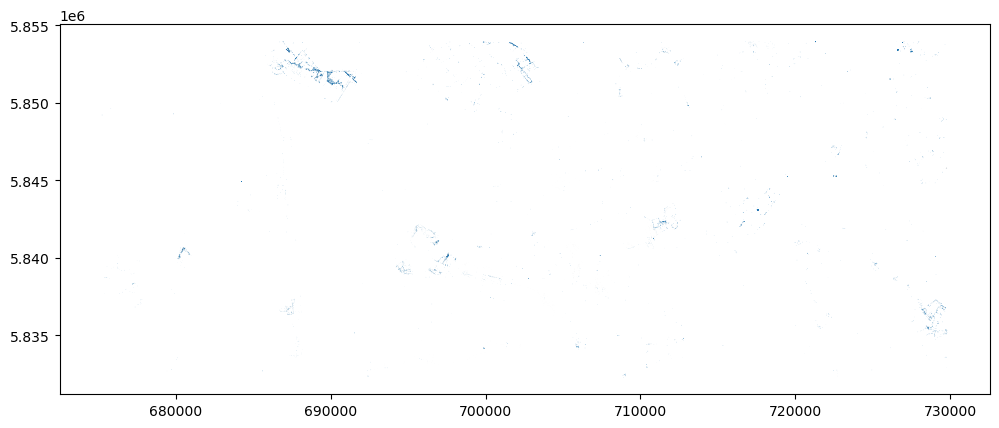

In [6]:
aoi_obs_gdf.plot(figsize=(12, 8))

### Create a GeoDataFrame with a grid
Construct a grid that covers the extent of the area of interest. This will later be used to aggregate the data into.


In [7]:
# total area for the grid
xmin, ymin, xmax, ymax= aoi_obs_gdf.total_bounds

# how many cells across and down
n_cells = 100
cell_size = (xmax - xmin) / n_cells

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))

grid_gdf = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs=aoi_epsg)

In [8]:
grid_gdf.head(3)

,geometry
0,"POLYGON ((674689.166 5832262.292, 674689.166 5..."
1,"POLYGON ((674689.166 5832808.040, 674689.166 5..."
2,"POLYGON ((674689.166 5833353.787, 674689.166 5..."


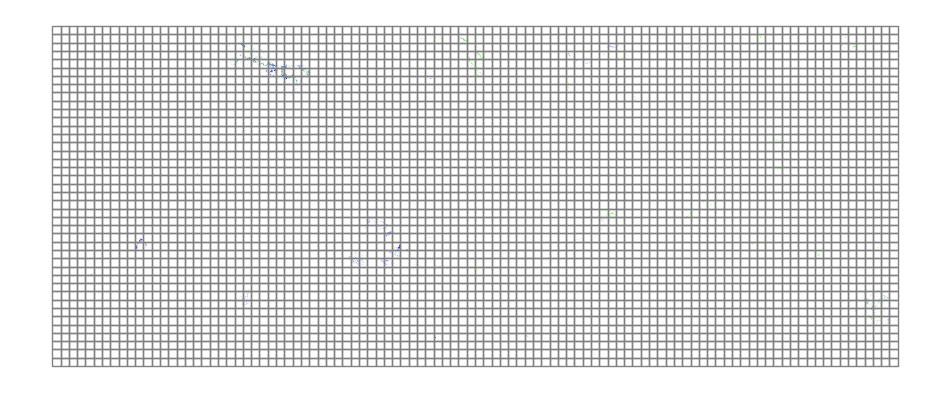

In [9]:
# plot the grid over the observations data
ax = aoi_obs_gdf.plot(markersize=0.5, figsize=(12, 8), column='straal', cmap='jet')
# plt.autoscale(False)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off");

### Merge the observations with the grid
Merge the observations with the grid using a spatial join. Then use a simple count to aggregate the data.

In [10]:
merged_aoi_gdf = gp.sjoin(aoi_obs_gdf, grid_gdf, how='left', predicate='within')

In [11]:
# make a count column
merged_aoi_gdf['n_obs'] = 1

# dissolve by count
dissolve = merged_aoi_gdf.dissolve(by='index_right', aggfunc='count')

# put the values into the grid
grid_gdf.loc[dissolve.index, 'n_obs'] = dissolve['n_obs'].values

/Users/robknapen/opt/mambaforge/envs/fairicube-pt2/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


<Axes: >

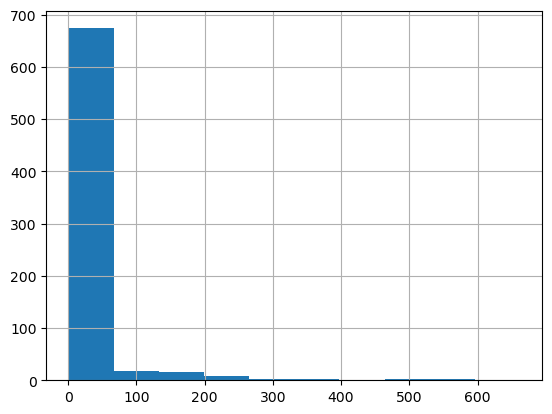

In [12]:
grid_gdf['n_obs'].hist()

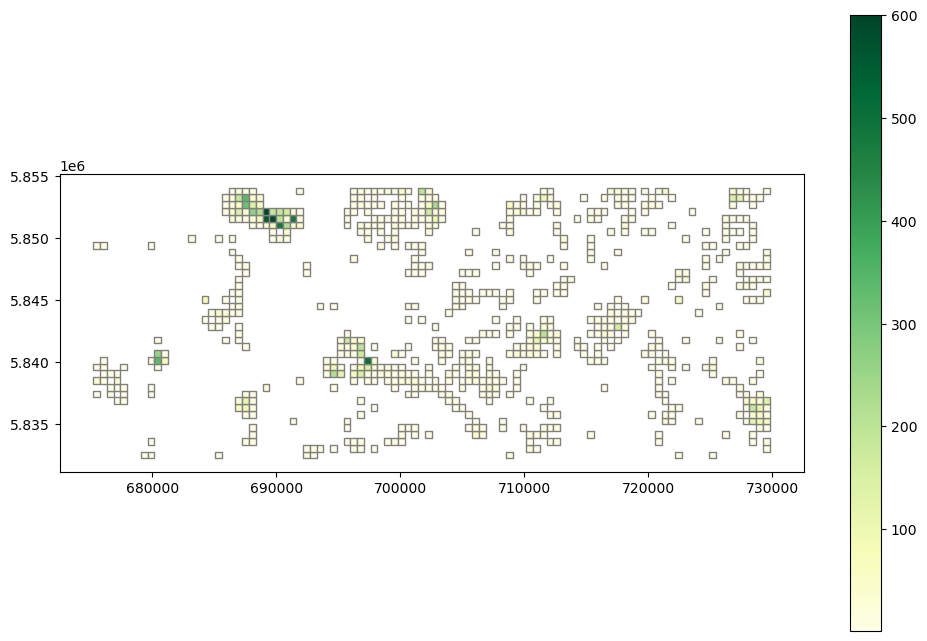

In [13]:
# plot the grid and the number of observations in each grid cell
grid_gdf.plot(
    column='n_obs',
    figsize=(12, 8),
    cmap='YlGn',
    vmax=600, # range max
    edgecolor='grey',
    legend=True
);

In [29]:
grid_gdf.explore(column='n_obs', cmap='viridis', vmax=250)